### EQL(Envelope Q Learning)

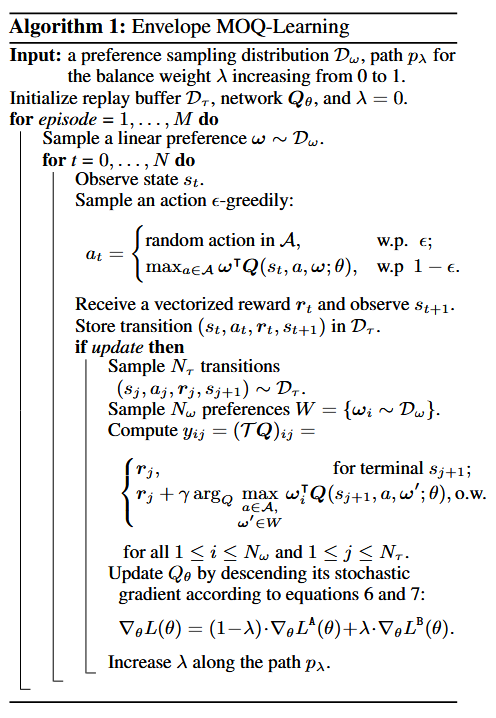

大致流程：

  - 每个episode开始时随机生成一个偏好w_kept，并保持一个episode
  - agent选择动作(take_action)进行环境交互，得到(s, a, r, n_s)
  - 存储(s, a, r, n_s)，优先级根据一个随机的w计算td_error
  - 进行更新(update)：获取一批数据(batch_size, s, a, r, n_s)，随机一组w，通过EQL_network获取Q、HQ、target_Q进行计算Loss和反向更新。


### Homotopy Optimization(同伦优化)

核心思想是在训练过程中动态调整损失权重，通过动态调整损失权重参数 β ，从易优化的辅助损失逐步过渡到目标损失。

1. 同伦路径组合损失

通过参数 $\beta \in [0, 1]$ 平滑过渡两个损失：

$$
L(\theta; \beta) = (1 - \beta) \cdot L_A(\theta) + \beta \cdot L_B(\theta)
$$

其中 $\beta$ 按指数路径从 $\beta_{\text{init}}$ 增长至 $\beta_{\text{uplim}} = 1.0$：

$$
\beta(t+1) = \beta(t) + \Delta\beta(t)
$$
$$
\Delta\beta(t) = (\beta(t) - \beta_{\text{init}}) \cdot \beta_{\text{expbase}} + \beta_{\text{init}} - \beta(t)
$$
$$
\beta_{\text{expbase}} = \left[ \tau \cdot (\beta_{\text{uplim}} - \beta_{\text{init}}) \right]^{1 / N_{\text{episode}}}
$$
$$
\Delta\beta(0) = \beta_{\text{expbase}} / \tau
$$

> **参数说明**：
> - $\beta_{\text{init}} = 0.01$：初始值（默认）
> - $\beta_{\text{uplim}} = 1.0$：上限值
> - $\tau = 1000$：缩放因子，控制初始增长步长
> - $N_{\text{episode}}$：总训练轮数

- **关键特性**：非线性 S 型增长（慢 → 快 → 慢），避免训练初期剧烈波动

| 损失类型 | 问题                          | 同伦优化的解决方案               |
|----------|-------------------------------|----------------------------------|
| $L_A$    | 存在大量局部最优解            | 初期主导训练，提供稳定初始解     |
| $L_B$    | 梯度景观平坦（多解等效）      | 后期主导训练，利用 $L_A$ 解初始化 |
| **组合** | 直接优化 $L_B$ 易发散         | 通过平滑路径连接两个损失的解空间 |

> 💡 **核心思想**：同伦优化本质是**课程学习（Curriculum Learning）** 在损失函数空间的应用——先学习简单任务（准确预测 Q 值），再逐步过渡到复杂任务（偏好对齐），显著提升收敛稳定性和样本效率。



### Importance Sampling (IS，重要性采样)

重要性采样是一种蒙特卡洛积分方法，用于估计期望值，特别是在难以从原始分布直接采样时。

**核心思想**：从另一个容易采样的分布（提议分布）中抽取样本，然后通过加权来修正样本的偏差。

1. 数学原理

我们想要计算函数 $f(x)$ 在分布 $p(x)$ 下的期望值：

$$
\mathbb{E}_p[f(X)] = \int f(x) p(x) \, dx
$$

但 $p(x)$ 难以直接采样。

引入一个容易采样的提议分布 $q(x)$，使得 $q(x) > 0$ 当 $p(x) > 0$：

$$
\mathbb{E}_p[f(X)] = \int f(x) \frac{p(x)}{q(x)} q(x) \, dx = \mathbb{E}_q\left[ f(X) \frac{p(X)}{q(X)} \right]
$$

其中 $w(x) = \dfrac{p(x)}{q(x)}$ 称为**重要性权重**。

2. 关键公式

用于计算函数 $f(x)$ 在分布 $p(x)$ 下的平均值

**非归一化估计**：

$$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^N f(x_i) \frac{p(x_i)}{q(x_i)}, \quad x_i \sim q(x)
$$

**归一化估计**（当 $p$ 的归一化常数未知时）：

$$
\hat{\mu} = \frac{\sum_{i=1}^N f(x_i) w_i}{\sum_{i=1}^N w_i}, \quad w_i = \frac{\tilde{p}(x_i)}{q(x_i)}
$$

其中 $\tilde{p}(x)$ 是未归一化的目标分布。

3. 方差分析

重要性采样的估计方差为：

$$
\text{Var}(\hat{\mu}) = \frac{1}{N} \text{Var}_q\left( f(X) \frac{p(X)}{q(X)} \right)
$$

**最优提议分布**（最小化方差）：

$$
q^*(x) = \frac{|f(x)| p(x)}{\int |f(x)| p(x) \, dx}
$$

4. 优势和局限性

**优势**：
1. **处理难采样分布**：可以从容易采样的分布中采样
2. **减少方差**：选择合适的提议分布可以显著降低方差
3. **灵活性**：可以结合多种采样方法

**局限性**：
1. **权重退化问题**：如果 $q(x)$ 与 $p(x)$ 差异过大，少数样本会主导结果
2. **高维问题**：在高维空间中，设计好的提议分布更困难
3. **计算开销**：需要计算每个样本的权重

🤔模型的计算复杂度瓶颈在哪？
  1. take action过程，考虑苏格拉底麦穗方法提取最大a

🤔优化方向：
  1. 使用其他算法显式寻找pareto前沿作为专家演示，加速EQL的学习